In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score
import copy

from scipy.stats.mstats import winsorize 
from scipy.stats import pointbiserialr, zscore, chi2_contingency
import itertools
import pandas_profiling
import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

import warnings

In [2]:
from collections import OrderedDict 

In [3]:
#Модуль вычисления корреляции Phi
def fik(dataframe):
    dataframe=pd.concat([dataframe, train['default']], axis=1)
    significance_overview = dataframe.significance_matrix()
    plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index,  title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(20,25))
    plt.tight_layout()
    

Data Description
Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [4]:
def ratio(df, digs=2):
    z=round(df[1]/df[0], digs)
    return z

In [5]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 70)

загружаем обучающий и тестовый образцы 

In [6]:
train=pd.read_csv('train.csv')
train.shape

(73799, 19)

In [7]:
test=pd.read_csv('test.csv')
test.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [8]:
train['set']=0

In [9]:
test['set']=1

In [10]:
full=pd.concat([train, test], axis=0)

In [11]:
full

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,set
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,1
36345,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,1
36346,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,1
36347,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,1


Проверим датасет на наличие пропусков

Среди признаков, только один признак Education содержит пропуски в количестве 307 записей. В разделе констрцуирование признаков мы проведём ииследование этой переменной и определимся со стратегией замены.

А пока посмотрим сколько у нас невозвратов по кредитам в тренировочном сете.

In [12]:
full['default'].value_counts(normalize=True)

0.0    0.873006
1.0    0.126994
Name: default, dtype: float64

In [13]:
baseline=ratio(train['default'].value_counts(normalize=True))

Итак, у нас почти 13% клиентов в обучающей выборке имеют дефолт.

Для того чтобы понять какие действия нам необходимо предпринять, мы начнём с анализа данных в обучающем сете и поймём как из них можно извлечь побольше информации. После этого мы объединим тестовый и тренировочный сеты.

Посмотрим как у нас выглядит срез датафрейма и какой тип имеют данные, сколько значений принимают признаки, и имеются ли преобладающие значения признаков.

In [14]:
for dataset in [train, test]:
    for col in dataset.columns: 
        display(f' {col :<20} {dataset[col].nunique() :<10}{dataset[col].value_counts(normalize=True).max().round(2) :<10} {dataset[col].dtypes}')
           
    print('____________________________________________________')

' client_id            73799     0.0        int64'

' app_date             120       0.01       object'

' education            5         0.53       object'

' sex                  2         0.56       object'

' age                  52        0.04       int64'

' car                  2         0.68       object'

' car_type             2         0.81       object'

' decline_app_cnt      21        0.83       int64'

' good_work            2         0.84       int64'

' score_bki            69096     0.0        float64'

' bki_request_cnt      38        0.26       int64'

' region_rating        7         0.37       int64'

' home_address         3         0.54       int64'

' work_address         3         0.61       int64'

' income               966       0.09       int64'

' sna                  4         0.64       int64'

' first_time           4         0.42       int64'

' foreign_passport     2         0.85       object'

' default              2         0.87       int64'

' set                  1         1.0        int64'

____________________________________________________


' client_id            36349     0.0        int64'

' app_date             120       0.01       object'

' education            5         0.53       object'

' sex                  2         0.56       object'

' age                  51        0.04       int64'

' car                  2         0.67       object'

' car_type             2         0.81       object'

' decline_app_cnt      19        0.83       int64'

' good_work            2         0.83       int64'

' score_bki            34287     0.0        float64'

' bki_request_cnt      34        0.26       int64'

' region_rating        7         0.37       int64'

' home_address         3         0.54       int64'

' work_address         3         0.61       int64'

' income               685       0.09       int64'

' sna                  4         0.64       int64'

' first_time           4         0.42       int64'

' foreign_passport     2         0.85       object'

' set                  1         1.0        int64'

____________________________________________________


Исходя из сходства частот преобладающих значений независимых признаков для обеих сетов, мы можем предположить что сеты образуют однородную совокупность и тенденции наблюдаемые в первом сете, 
скорее всего будут проявляться и во втором.

Итак, какие данные имеются в нашем распоряжении?

В датасете присутствуют 13 численных (12 int64 и 1 float64)  и 6 категориальных признаков. Численный признак default  является нашей целевой переменной. 

По своему типу данны подразделяются на:

* Номинальные:
    * Бинарные:
        * sex
        * car
        * car_type            
        * foreign_passport
        * default            
        * good_work
    * Тринарные:            
        * home_address
        * work_address
* Ординальные:
    * education
    * sna
* Относительные:
    * client_id
    * age
    * decline_app_cnt
    * bki_request_cnt
    * region_rating
    * income
    
    * first_time

Посмотрим, имеются ли у нас  корреляции признаков с целевой переменной default

In [15]:
train.corr(method='spearman').default.sort_values(ascending=False)

default            1.000000
score_bki          0.171471
sna                0.124309
decline_app_cnt    0.119189
home_address       0.087961
work_address       0.082000
bki_request_cnt    0.075556
age               -0.026739
client_id         -0.039281
good_work         -0.043361
income            -0.058849
region_rating     -0.085848
first_time        -0.105178
set                     NaN
Name: default, dtype: float64

In [16]:

# warnings.filterwarnings('error')

Корреляция независимых признаков с целевой переменной слабая, самую тесную положительную связь демонстрируют
score_bki, sna, decline_app_cnt, а самую тесную отрицательную- first_time. При этом decline_app_cnt имеет низкую оценку связи по phi-k.

Проведём раздельную предобработку данных и конструирование  признаков.

### 1. Работа с бинарными данными

Отберём все бинарные данные и изучим их

In [17]:
bin_cols=full.columns[train.apply(pd.Series.nunique).values==2] 

In [18]:
bins=full[bin_cols]

In [19]:
bins.head()

,sex,car,car_type,good_work,foreign_passport,default
0,M,Y,Y,0,N,0.0
1,F,N,N,0,N,0.0
2,M,Y,N,0,Y,0.0
3,F,N,N,0,N,0.0
4,M,N,N,1,Y,0.0


In [20]:
bins=pd.concat([bins, pd.get_dummies(bins.select_dtypes(exclude='int64'), 
                                     drop_first=True, dtype='float64' )], 
               axis=1).select_dtypes(exclude='object')

Векторизируем наши переменные и проверим насколько коррелированы будут переменные. При векторизации будем убирать одну из получившихся при разбиении переменных, а также исходные категориальные параметры.

In [21]:
bins.corr(method='spearman').round(3)

,good_work,default,default,sex_M,car_Y,car_type_Y,foreign_passport_Y
good_work,1.000,-0.043,-0.043,-0.044,0.002,0.016,0.048
default,-0.043,1.000,1.000,0.020,-0.043,-0.057,-0.067
default,-0.043,1.000,1.000,0.020,-0.043,-0.057,-0.067
sex_M,-0.044,0.020,0.020,1.000,0.277,0.225,0.086
car_Y,0.002,-0.043,-0.043,0.277,1.000,0.699,0.107
car_type_Y,0.016,-0.057,-0.057,0.225,0.699,1.000,0.145
foreign_passport_Y,0.048,-0.067,-0.067,0.086,0.107,0.145,1.000


In [22]:
bins.head()

,good_work,default,default,sex_M,car_Y,car_type_Y,foreign_passport_Y
0,0,0.0,0.0,1.0,1.0,1.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,1.0,1.0,0.0,1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,1.0


Обратим внимание на коэффициенты корреляции независимых признаков между собой. и целевой переменной

<AxesSubplot:>

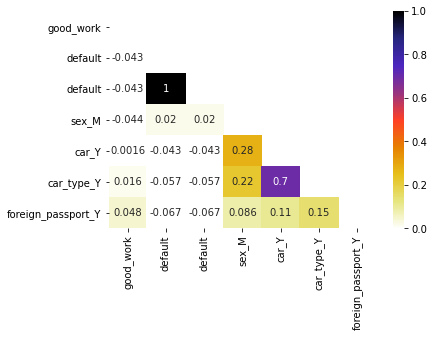

In [23]:
sns.heatmap(bins.corr(), vmin=0, vmax=1, annot = True, cmap= 'CMRmap_r',
            mask=np.triu(bins.corr(method='spearman')))

In [24]:
bin_cols=bins.columns # количество ппризнаков у нас увеличилось соответственно обновляем их список

Из данных корреляции видно что корреляции бинарных признаков с целевой переменной по модулю не превышают значений 0,067. Попробуем сконструировать критерий с более высокой степенью корреляции. Для этого:
1) построим кросстабуляции бинарных признаков протв целевой переменной. 

2) оценим отношения дефолт/недефолт для каждого из бинарных значений. После этого считаем их отношения и вычитаем из результата единицу, полученный коэффициент далее будем называть коэффициентом преобладания. Более высокие значения коэффициента соответствуют более высоким значениям корреляции.

3) Осуществим отбор переменных имеющих максимальные значения нашего коэффициента (от большего к меньшему) и их аггрегирование в единый параметр с попутной проверки корреляции с целевой переменной.

In [25]:
bins['fp_ct_gw']=np.where((bins['foreign_passport_Y']==0)
                          & (bins['car_type_Y']==0) 
                          & (bins['good_work']==0), 0.0, 1.0) 
bins['fp_ct_gw'].corr(train['default'])

-0.056388896514748515

Итак, из трёх бинарных категориальных признаков мы создали один признак комбинации сочетания следующих свойств: Отсутствие паспорта, машины и оценки в качестве хорошего работника, который демонстрирует слабое отрицательное влиение на риск дефолта.

Этому признаку мы и доверим представлять бинарные данные  в нашей модели.

Как мы видим, тесной связи бинарных признаков с целевой переменной не наблюдается. Сами признаки при этом обнаружтвают высокую степень зависимости. Так существует сильная связь между признаками наличие автомобиля и наличие иностранного автомобиля, а также слабая зависимость между полом и наличием автомобиля, между наличием иномарки и наличием загранпаспорта.

In [26]:
# bins1=bins[['fp_ct_gw', 'foreign_passport_Y']]     
# bins=bins1

In [27]:
# bins2=bins[['fp_ct_gw']]     

In [28]:
bins.columns

Index(['good_work', 'default', 'default', 'sex_M', 'car_Y', 'car_type_Y',
       'foreign_passport_Y', 'fp_ct_gw'],
      dtype='object')

### Тринарные признаки

In [29]:
trin_cols=full.columns[full.apply(pd.Series.nunique).values==3]
trins=full[trin_cols]
#для векторизации меняем тип данных с int64 на float64

Двигаемся дальше. Вспоминаем наши тринарные категориальные переменные и также подвергнем их  преобразованию. Мы попробуем рассмотретиь их в качестве порядковой шкалы (предполагая наличие какой-то связи номера и верояности дефолта, к примеру номер зоны характеризующей расстояние от центра города и  т. п.), а также подвергнуть векторизации чтобы понять насколько тесно они сами по себе (абстрагируясь от присвоенного кода) коррелируют с регрессиией.

Преобразуем наши переменные. для начала соберём все бинарные данные  
Здесь мы попытаемся понять, несёт ли какую-то смысловую нагрузку кодификация адресов работы и проживания. Поэтому мы не будем удалять исходные столбцы до сопоставления.

По результатам сопоставления мы выберем тринарные признаки которые будем использовать в нашей модели.

In [30]:
trins=pd.concat([trins, pd.get_dummies(trins.astype('object'), dtype='float64')], axis=1)
trins.head()

,home_address,work_address,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3
0,1,2,1.0,0.0,0.0,0.0,1.0,0.0
1,2,3,0.0,1.0,0.0,0.0,0.0,1.0
2,1,2,1.0,0.0,0.0,0.0,1.0,0.0
3,2,3,0.0,1.0,0.0,0.0,0.0,1.0
4,2,3,0.0,1.0,0.0,0.0,0.0,1.0


Мы видим что:
    
1) для домашних адресов 1 и 2 мы имеем слабые корреляции с целевой переменной (отрицательную и положительную) причём их связь с ней тесне чем у исходного категориального признака при его восприятии в качестве порядковой шкалы. Следовательно для этих адресов важнее скрытые признаки не отражённые упорядочиванием.

2) рабочие адреса ведут себя по другому, у них порядковая переменная связана с целевой переменной теснее, хотя рабочий адрес 3 практически дотягивает до значения корреляции для исходного порядкового признака. При этом отсутствуют векторизированны признаки близкие к нулю (как home_3). Возможно присутствует какая-то географическая либо иная закономерность позволяющяя качественно их сравнивать.

Посмотрим как распределены наши значения для исходных тринарных признаков

In [31]:
a=trins[['home_address', 'work_address']].apply(pd.value_counts, normalize=True).round(2).T*100
a

,1,2,3
home_address,44.0,54.0,2.0
work_address,11.0,28.0,61.0


Рассмотрим комбинацию "рабочий адрес2- домашний адрес 3", которая преобладала в наших подсетах для дефолтников и недефолтников.

In [32]:
trin_cols=trins.columns

In [33]:
trins['adresses_h2w3']=np.where((trins['home_address']==2) & (trins['work_address']==3), 1.0, 0.0) 
# print(trins[['adresses_h2w3']].corrwith(train['default'], method='kendall').round(3))
trins.corrwith(trins.adresses_h2w3, method='spearman').sort_index()

adresses_h2w3     1.000000
home_address      0.887065
home_address_1   -0.932007
home_address_2    0.964505
home_address_3   -0.137574
work_address      0.817890
work_address_1   -0.370820
work_address_2   -0.651823
work_address_3    0.838517
dtype: float64

Мы получили признак который связан с целевой переменной теснее чем любой из порядковых и вектороизированных признаков выражающих адреса. При этом он относительно слабо коррелирует с векторизатом work_address_1. Оба этих признака делегируем в модель

Делегируем в модель переменные 'adresses_h2w3', 'work_address_1'

In [34]:
# trins1=trins[['adresses_h2w3', 'home_address', 'work_address' ]]
# trins=trins1

In [35]:
# trins2=trins[['adresses_h2w3']]

In [36]:
trins.columns

Index(['home_address', 'work_address', 'home_address_1', 'home_address_2',
       'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3',
       'adresses_h2w3'],
      dtype='object')

In [37]:
# fik(trins)

### квартенарные переменные

С квартенарным признаками мы поступим аналогично тринарным.

In [38]:
quart_cols=full.columns[full.apply(pd.Series.nunique).values==4]
quartins=full[quart_cols]

Проведём оценку их коррелированности с целевой переменной, кросс-табуляцю и векторизацию

In [39]:
quartins.apply(pd.value_counts, normalize='index').round(2).T*100 

,1,2,3,4
sna,64.0,14.0,6.0,16.0
first_time,17.0,16.0,42.0,25.0


In [40]:
quartins=pd.concat([quartins, pd.get_dummies(quartins.astype('object'), dtype='float64')], axis=1)
quartins.head()

,sna,first_time,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,4,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,4,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
quartins.corrwith(train.default, method='kendall').sort_index()

first_time     -0.063540
first_time_1    0.051671
first_time_2    0.026118
first_time_3   -0.013744
first_time_4   -0.050360
sna             0.078031
sna_1          -0.076650
sna_2           0.019079
sna_3           0.016227
sna_4           0.072068
dtype: float64

Векторизация результатов не дала, векторизированные компоненты связаны с целевой фунцией слабее, хотя sna_1 практически дотягивается до значения корреляции исходного признака.

Посмотри как все получившиеся признаки между собой коррелируют

Мы  видим, что параметры sna и first_time имеют высокий уровень отрицательной корреляции. Попробуем агрегировать их и провести бинаризацию. Проводим кросстабуляцию и смотрим на преобладающие сочетания значений признаков. К таколвым у нас относится комбинация sna=1 и first_time=3 или 4.

In [42]:
round(pd.crosstab(quartins.sna, quartins.first_time, normalize=True)*100, 1)

first_time,1,2,3,4
sna,,,,
1,3.2,7.9,30.2,22.9
2,2.4,4.0,6.5,1.4
3,1.5,1.8,2.0,0.3
4,9.5,2.0,3.6,0.8


In [43]:
quartins['sna_ft']=np.where((quartins['sna']==1) & (quartins['first_time']>2), 0.0, 1.0)
# quartins[['sna_ft']].corrwith(train['default'], method='spearman')

In [44]:
quartins[['sna', 'first_time']].corrwith(quartins['sna_ft'], method='spearman')

sna           0.773114
first_time   -0.699644
dtype: float64

полученный нами признак превосходит исходные параметры постепени корреляции с целевой переменной, а также более коррелирован с ними чем сами они между собой. Мы берём его в модель

А как с ним коррелируют остальные признаки?



In [45]:
# quartins1=quartins[['sna', 'first_time']]

In [46]:
quartins.columns

Index(['sna', 'first_time', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1',
       'first_time_2', 'first_time_3', 'first_time_4', 'sna_ft'],
      dtype='object')

### Пятиуровневая переменная Education

Порядковый признак Education принимает 5 уровней, самый низкий из которых SCH соответствует школьному образованию, а самый высокий- учёной степени PhD. Для оценки перспективности посмотрим как распределён показатель, заполним пропуски, перекодируем его, а также проведём векторизацию, после чего сравним степень их корреляции с целевой переменной.

In [47]:
pd.concat([full.education.value_counts(dropna=False), full.education.value_counts(dropna=False, normalize=True).round(4)*100], axis=1)

,education,education
SCH,57998,52.65
GRD,34768,31.56
UGR,14748,13.39
PGR,1865,1.69
NaN,478,0.43
ACD,291,0.26


Вклад наблюдений с отсутствующим образованием незначителен (0,42%), и в принципе мы могли бы удалить эти данные. Но с другой стороны датасет вполне однородный и эти наблюдения можно оставить заменив их значениями одного из соседних уровней образования.

In [48]:
full['default'].groupby(full['education'], 
                         dropna=False).apply(pd.value_counts, 
                                             normalize=True).unstack().round(4)*100

,0.0,1.0
education,,
ACD,95.88,4.12
GRD,90.99,9.01
PGR,93.56,6.44
SCH,84.94,15.06
UGR,86.85,13.15
NaN,88.60,11.40


Для отсутствующих данных, частота невозврата занимает промежуточное положение между частотами невозврата для имеющих степень бакалавра и степень магистра. 

Поскольку в нашем датасете доля группы заёмщиков UGR меньше доли группы заёмщиков GRD (32 и 13% соответственно), представляется логичным отнести заёмщиков с неизвестным уровнем образования к более крупной группе GRDm, что мы и сделаем

In [49]:
full.education.fillna('GRD', inplace=True)

In [50]:
full.default.groupby(full['education'], dropna=False).value_counts(normalize=True).round(4).unstack().sort_values(
    by=0, ascending=False)*100


default,0.0,1.0
education,,
ACD,95.88,4.12
PGR,93.56,6.44
GRD,90.96,9.04
UGR,86.85,13.15
SCH,84.94,15.06


Мы пришли к выводу о том что самыми надёжными заёмщиками в нашей выборке предсказуемо оказались лица с научными степенями, в то время заёмщики имеющие школьное образование и закончившие бакалавриат имели максимальный риск невозврата.

Проведём векторизацию, а далее отранжируем уровни образования согласно наблюдаемым частотам дефолта.

In [51]:
pents=pd.concat([full['education'], pd.get_dummies(full['education'], dtype='float64')], axis=1)

Корреляции векторизированных признаков образования с целевой переменной невысоки (в районе 0,075 по модулю для значений SCH и GRD).
Проведём кодирование

In [52]:
pents['education'].replace({'SCH':4.0, 'UGR':3.0, 'GRD':2.0, 'PGR':1.0, 'ACD':0.0}, inplace=True)


In [53]:
# pents=pd.concat([pents, coder], axis=1)
# drop('education', axis=1).astype('float')
pents.columns

Index(['education', 'ACD', 'GRD', 'PGR', 'SCH', 'UGR'], dtype='object')

In [54]:
pents.corrwith(train['default'])

education    0.054786
ACD         -0.010578
GRD         -0.048872
PGR         -0.015332
SCH          0.047878
UGR          0.004149
dtype: float64

Сравнив векторизированные и порядковый признаки мы останавливаем свой выбор на порядковой переменной Education

In [55]:
# pents=pents['education']

### Семииуровневая переменная region rating

Проделываем аналогичные операции

In [56]:
pd.concat([full.region_rating.value_counts(dropna=False),
           full.region_rating.value_counts(dropna=False, 
                                            normalize=True).round(4)*100], axis=1)

,region_rating,region_rating
50,40981,37.21
60,23999,21.79
40,17947,16.29
80,17170,15.59
70,9304,8.45
30,434,0.39
20,313,0.28


Распределение регионов по рейтингу близкое к нормальному.

Посмотрим как распределены по регионам дефолты

In [57]:
f.default.groupby(train['region_rating'], 
                      dropna=False).value_counts(normalize=True).round(4).unstack().sort_values(by=0,
                                                                                                ascending=False)*100

NameError: name 'f' is not defined

Между рейтингом и количеством невозвратов прослеживается обратная связь, скорее всего рейтинги определяют надёжность жителей региона в качестве заёмщиков. Посмотрим какова корреляция этого признака с целевым.

In [58]:
hepts=pd.concat([full['region_rating'], pd.get_dummies(full['region_rating'], dtype='float64')], axis=1)


В модели будем использовать упорядоченный рейтинг.

In [59]:
hepts=hepts['region_rating']

Соберём в единый датафрейм все признаки которые мы рассмотрели

In [60]:
X_low=pd.concat([bins, trins, quartins, pents, hepts], axis=1)

проведём нормализацию параметров education и region_rating.

In [61]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [62]:
ss=StandardScaler()

In [63]:
X_low[['education', 'region_rating']] = ss.fit_transform(X_low[['education', 'region_rating']])

На этом мы заколнчили подготовку 2-7 мерных признаков. Далее мы будем обрабатывать количественные признаки боольшей размерности

#### Признаки размерности 8+

Итак, перед нами оставшиеся 7 признаков, среди которых один временной ряд. Посмотрим их описания 

In [64]:
high_cols=full.columns[full.apply(pd.Series.nunique).values>7]
high_cols

Index(['client_id', 'app_date', 'age', 'decline_app_cnt', 'score_bki',
       'bki_request_cnt', 'income'],
      dtype='object')

Проведём преобразование признаков 

In [65]:
highs=full[high_cols]

In [66]:
highs.corr(method='spearman')

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,income
client_id,1.000000,0.017965,-0.020080,-0.059888,-0.006253,-0.003596
age,0.017965,1.000000,-0.121611,-0.111900,0.048486,-0.096399
decline_app_cnt,-0.020080,-0.121611,1.000000,0.199439,0.110987,-0.011404
score_bki,-0.059888,-0.111900,0.199439,1.000000,0.131603,0.005646
bki_request_cnt,-0.006253,0.048486,0.110987,0.131603,1.000000,0.068370
income,-0.003596,-0.096399,-0.011404,0.005646,0.068370,1.000000


In [67]:
# highs.corrwith(train['default'], method='spearman')

Попробуем винсоризировать переменную income с тяжёлыми хвостами

In [68]:
towins_cols=['income']
towins=highs[towins_cols]

In [69]:
for col in towins_cols:
    towins[col]=winsorize(towins[col], limits = 0.15)
# towins.corrwith(train['default'], method='spearman')

C:\Users\User\anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
highs['income']=towins['income']

C:\Users\User\anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
highs['decline_app_cnt']=np.log10(highs['decline_app_cnt']+1)


C:\Users\User\anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
highs[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt']]=ss.fit_transform(highs[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt']])

C:\Users\User\anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\spyder\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


В корреляционное сопоставление не попадл один из нашихпризнаков- временной ряд 'app_date'. 
Для того чтобы извлечь необходимую нам информацию, осуществим преобразование этого параметра

In [73]:
highs.head(3)

,client_id,app_date,age,decline_app_cnt,score_bki,bki_request_cnt,income
0,25905,01FEB2014,1.975219,-0.418815,-0.208688,-0.443335,18000
1,63161,12MAR2014,1.714757,-0.418815,0.745419,0.438921,19000
2,25887,01FEB2014,-1.237142,2.621662,0.993988,-0.443335,30000


In [74]:
time=pd.DataFrame()

In [75]:
time['app_date'] = pd.to_datetime(highs.app_date)

In [76]:
time['app_monthday']= time['app_date'].apply(lambda x: x.day).astype('int64')

In [77]:
time['month']=time['app_date'].dt.month.astype('int64')

In [78]:
time['app_weekday']=time['app_date'].dt.weekday.astype('int64')

In [79]:
time['app_week']=time['app_date'].dt.isocalendar().week.astype('float64')

In [80]:
time['dayofyear']=time['app_date'].apply(lambda x: x.dayofyear).astype('int64')
# highs['dayofyear']=mms.fit_transform(highs[['dayofyear']])
# highs['dayofyear'].corr(train['default'])

In [81]:
# time=pd.concat([time, train['default']], axis=1)

In [82]:
time.corr()

,app_monthday,month,app_weekday,app_week,dayofyear
app_monthday,1.000000,-0.166926,-0.012515,0.097220,0.096869
month,-0.166926,1.000000,-0.034066,0.963104,0.964939
app_weekday,-0.012515,-0.034066,1.000000,-0.096910,-0.038162
app_week,0.097220,0.963104,-0.096910,1.000000,0.998266
dayofyear,0.096869,0.964939,-0.038162,0.998266,1.000000


In [83]:
# fik(time.drop('default', axis=1))

In [84]:
# ratio(train['default'].groupby(highs['app_weekday']).value_counts().unstack(), 3)

In [85]:
# time[['app_week']].corrwith(time['default'], method='spearman')

In [86]:
# train['app_week']=train['app_date'].dt.isocalendar().week.astype('int64')

In [87]:
time['app_week_bin']=np.where(time['app_week']<15, 1, 0)
# time[['app_week_bin']].corrwith(time['default'], method='spearman')

In [88]:
cut_labels=[0, 1, 2, 3, 4, 5, 6, 7,]
highs['age_cut']=pd.qcut(highs.age, q=8, labels=cut_labels).astype('int64')
# highs[['age_cut']].astype('int64').corrwith(train['default'])


C:\Users\User\anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
# highs=highs[['income', 'client_id', 'age_cut', 'bki_request_cnt', 'decline_app_cnt']]

In [90]:

# pd.crosstab(train['age_cut'], train['default'],  normalize='index').round(2)*100
# train['age_cut']=train['age_cut'].astype('float64')
# highs['age_cut']

Мы не видим разницы по возрасту и оценке заёмщика как хорошего работника. У дефолтников в имеется один отказ в заявке на кредит, у среднего недефолтника отказов не было. Интересно при этом что среди недефолтников встречается клиент с количеством отказов 33, 
что на 50% выше макксимального значения для дефолтников. Уровень зарплаты у обеих групп очень похож, но с увеличением зарплаты наблюдается отставание дефолтников.

Посмотрим теперь на модальные значения параметров, здесь мы вернём в рассмотрение адреса.

Мы видим модальные различия только для двух параметров: возраста (дефолтники модально моложе на пять лет) и запрос в бюро кредитных историй (модально один запрос у дефолтников, при отсутствии запросов у недефолтников). 

Итак наши данные более не содержат пропусков и самой время проверить насколько тесно независимые переменные связаны между собой и целевой переменной. 

In [91]:
highs['income']=np.log10(highs['income'])


C:\Users\User\anaconda3\envs\spyder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
# X_high=highs[['income', 'bki_request_cnt', 
#               'decline_app_cnt_om', 'score_bki', 'decline_app_cnt', 'app_week_bin' 
#              ]]

In [93]:
X_high=highs
X_high.drop('app_date', axis=1, inplace=True)

C:\Users\User\anaconda3\envs\spyder\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [94]:
X_low.dtypes

good_work               int64
default               float64
default               float64
sex_M                 float64
car_Y                 float64
car_type_Y            float64
foreign_passport_Y    float64
fp_ct_gw              float64
home_address            int64
work_address            int64
home_address_1        float64
home_address_2        float64
home_address_3        float64
work_address_1        float64
work_address_2        float64
work_address_3        float64
adresses_h2w3         float64
sna                     int64
first_time              int64
sna_1                 float64
sna_2                 float64
sna_3                 float64
sna_4                 float64
first_time_1          float64
first_time_2          float64
first_time_3          float64
first_time_4          float64
sna_ft                float64
education             float64
ACD                   float64
GRD                   float64
PGR                   float64
SCH                   float64
UGR       

In [95]:
X=pd.concat([X_low, X_high], axis=1)

In [96]:
# X=X.drop('app_date', axis=1)

In [97]:
X=X.drop(['default'], axis=1)

In [98]:
y = full['default'].values

In [99]:
# .drop('app_date', axis=1, inplace=True)

# X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.20, random_state=42)
X_train=X[full['set']==0]
X_test=X[full['set']==1]
y_train=full[full['set']==0]['default']
y_test=full[full['set']==1]['default']
# y_test=pd.read_csv('')

In [100]:
a=pd.DataFrame(X_test['client_id'], columns=['client_id'])
# b=pd.concat(a, y_prob)
# .concat(y_prob)
             
#              y_prob,  columns=['client_id', 'default'])

In [101]:
a['default']=y_prob

NameError: name 'y_prob' is not defined

In [102]:
import xgboost

In [103]:
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

In [104]:
y_pred=model.predict(X_test)

In [105]:
y_prob=model.predict_proba(X_test)

In [106]:
y_prob = y_prob[:,1]


In [107]:
a=pd.DataFrame(X_test['client_id'], columns=['client_id'])

In [108]:
a['default']=y_prob

## SUBMISSION

In [109]:
a.to_csv(r'C:\Users\User\Desktop\file1.csv', index = False, header=True)